In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import parallel_backend

In [9]:
data_path = "./data/Fraud.csv"
df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
display(df.head())


Dataset shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Drop unused columns
df = df.drop(["nameOrig", "nameDest"], axis=1)

# Encode transaction type
le = LabelEncoder()
df["type"] = le.fit_transform(df["type"])


In [4]:
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
# Scale for some models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [10]:
# Define models
models = {
    "HistGradientBoosting": HistGradientBoostingClassifier(max_iter=200),
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='saga',
        n_jobs=14  # Limit cores
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=1000,
        class_weight='balanced',
        random_state=42,
        n_jobs=14  # Limit cores
    )
    # "SVM (RBF)": SVC(
    #     kernel='rbf',
    #     class_weight='balanced'
    # )
}

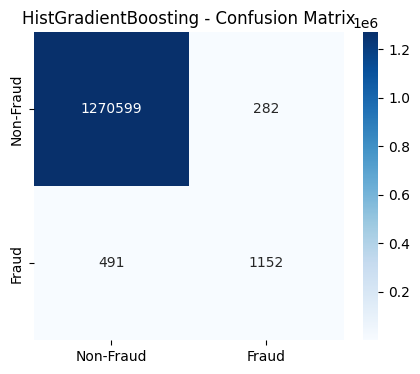


HistGradientBoosting Results:
Accuracy: 0.9993925458380353
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.80      0.70      0.75      1643

    accuracy                           1.00   1272524
   macro avg       0.90      0.85      0.87   1272524
weighted avg       1.00      1.00      1.00   1272524



/home/linux/Documents/codes/Fraud-Detection/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


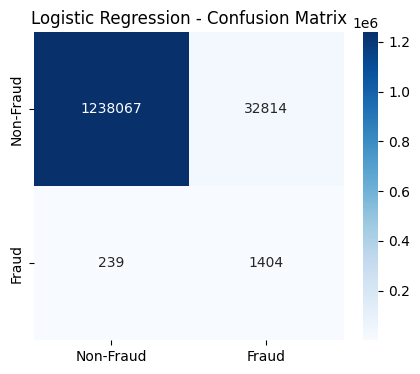


Logistic Regression Results:
Accuracy: 0.9740256372374902
              precision    recall  f1-score   support

           0       1.00      0.97      0.99   1270881
           1       0.04      0.85      0.08      1643

    accuracy                           0.97   1272524
   macro avg       0.52      0.91      0.53   1272524
weighted avg       1.00      0.97      0.99   1272524



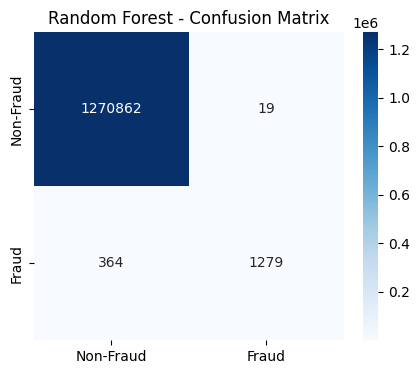


Random Forest Results:
Accuracy: 0.9996990233583021
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.99      0.78      0.87      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.89      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



In [12]:
# Function to train and evaluate a single model
def train_and_eval(name, model):
    if name in ["Logistic Regression", "SVM (RBF)"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Non-Fraud", "Fraud"],
                yticklabels=["Non-Fraud", "Fraud"])
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
    
    print(f"\n{name} Results:")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))
    
    return {"Model": name, "Accuracy": acc}

# Run models sequentially to show results one by one
results = []
for name, model in models.items():
    result = train_and_eval(name, model)
    results.append(result)



Model Accuracy Comparison:


,Model,Accuracy
0,HistGradientBoosting,0.999393
1,Logistic Regression,0.974026
2,Random Forest,0.999699


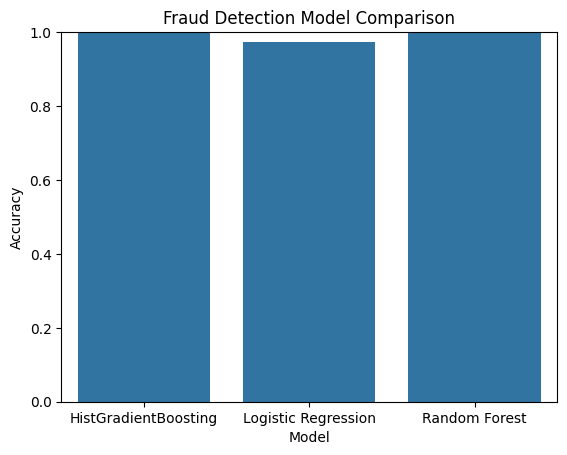

In [13]:
# Compare accuracies
results_df = pd.DataFrame(results)
print("\nModel Accuracy Comparison:")
display(results_df)

sns.barplot(data=results_df, x="Model", y="Accuracy")
plt.title("Fraud Detection Model Comparison")
plt.ylim(0, 1)
plt.show()